In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="2"

Sat Jan 27 18:04:21 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   44C    P0    47W / 300W |     35MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [3]:
from model.main.enc_prior_latent_quantizer_dec import Model
from model.encoder.net_64_encoder import Encoder
from model.prior.dalle_rand_prior import Prior
from model.latent.dalle_norm_lse_latent import Latent
from model.quantizer.dalle_nearest_quantizer import Quantizer
from model.decoder.net_64_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.img_size = 64
hp.n_resblocks = 6
hp.z_dim = 64
hp.n_prior_embeddings = 512
hp.init_log_sigma = 0
hp.const_sigma = False
hp.quantize = False
hp.prior_mu = 0.999
hp.z_activation = F.tanh
hp.M = hp.n_prior_embeddings
hp.norm_exp = 0.5

In [5]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Quantizer(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 1.2191162109375
encoder.encoder 1.2191162109375
prior 0.126953125
latent 3.814697265625e-06
quantizer 0.0
decoder 1.0611686706542969
decoder.decoder 1.0611686706542969
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train_dalle/train01.27-4/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model_list, optimizer_list = load_model_list(save_dir, 660000, model_list, optimizer_list)

total 7308
-rw-rw-r-- 1 scpark scpark    5697  1월 27 18:04 events.out.tfevents.1706346228.GPUSVR11
-rw-rw-r-- 1 scpark scpark 7471539  1월 27 18:04 save_0


In [7]:
path = '/data/scpark/save/lse/train_dalle/train01.19-7_tanh_0.999_lr1e-4/save_600000'
checkpoint = torch.load(path, map_location=torch.device('cpu'))
# warm start
for i, (model, optimizer) in enumerate(zip(model_list, optimizer_list)):
    model.load_state_dict(checkpoint['models_state_dict'][i], strict=False)
    
print('done')

done


### Dataset

In [8]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.img_size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
print('done')

done


In [9]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [10]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(8):
        plt.subplot(1, 8, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [11]:
def linear(start_value, end_value, current_index, start_index, end_index):
    if current_index > end_index:
        return end_value
    if current_index < start_index:
        return start_value

    grad = (end_value - start_value) / (end_index - start_index)
    y = start_value + grad * (current_index - start_index)

    return y

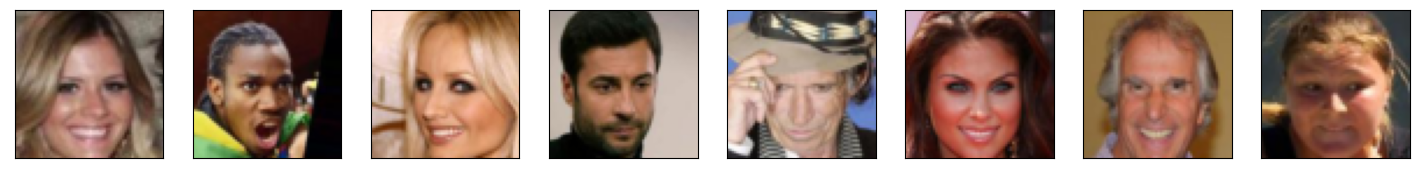

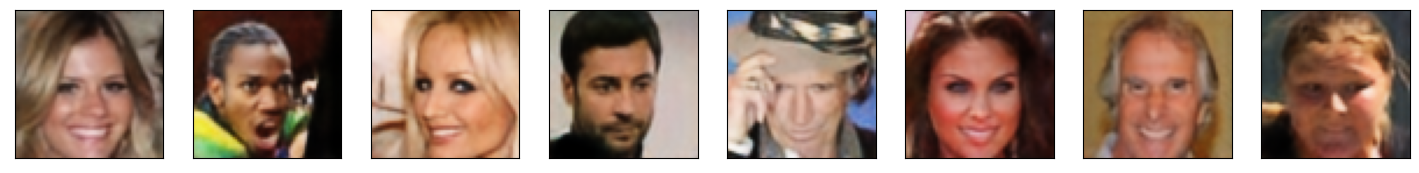

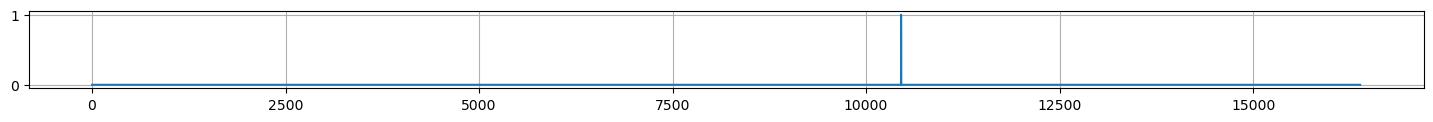

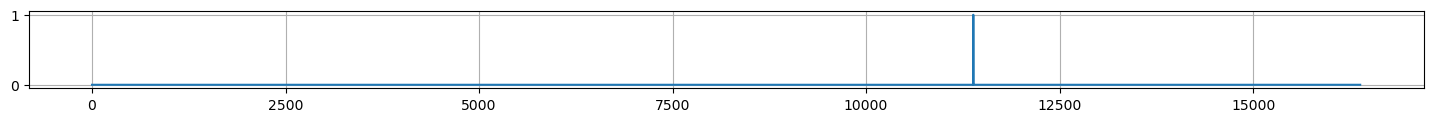

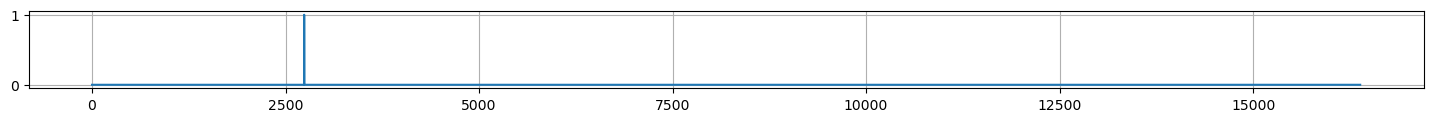

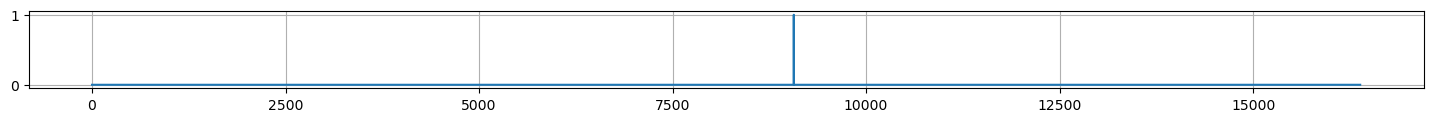

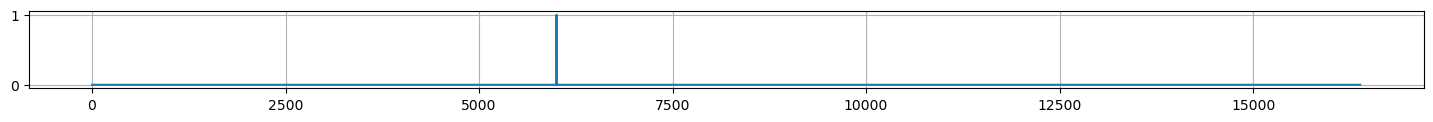

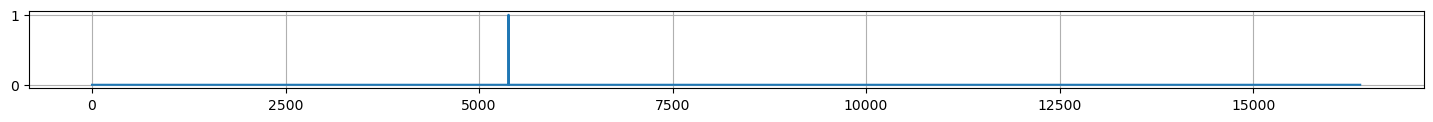

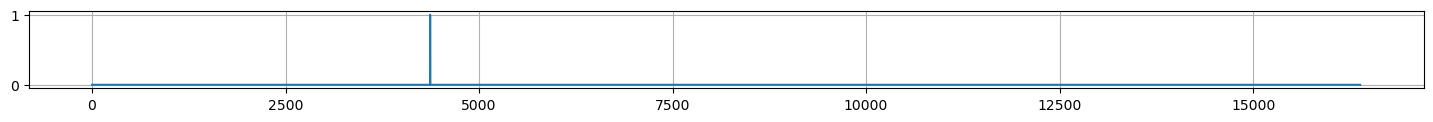

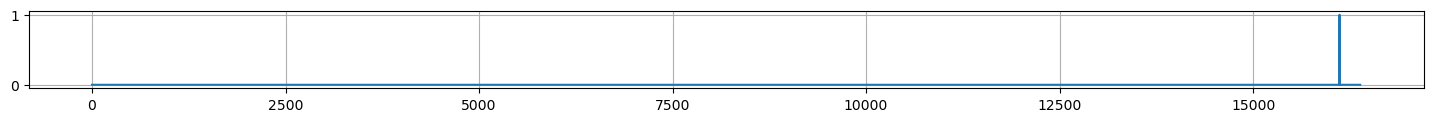

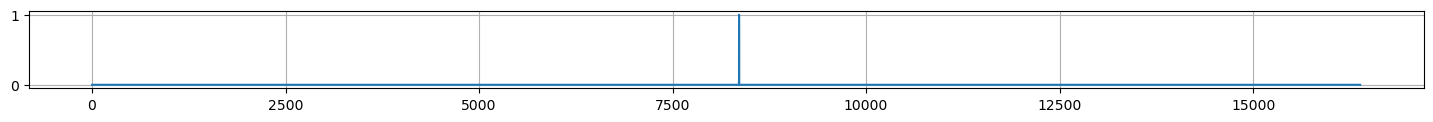

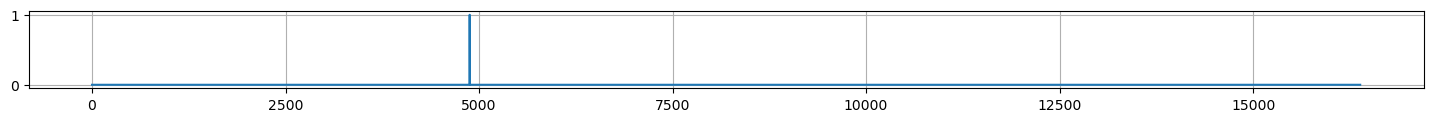

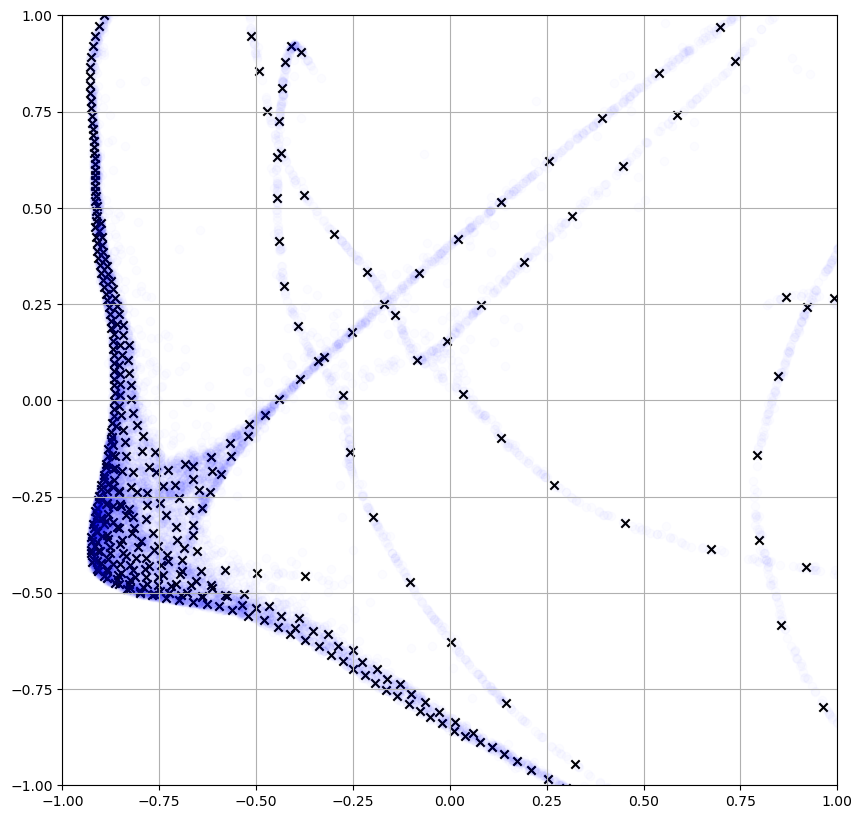

1
lse_loss 30166.84375
commit_loss 8.884457201929763e-05
recon_loss 0.002116704359650612
2
lse_loss 28850.5546875
commit_loss 8.78453574841842e-05
recon_loss 0.0012573989806696773
3
lse_loss 28193.4921875
commit_loss 7.773014658596367e-05
recon_loss 0.0013755213003605604
4
lse_loss 24342.412109375
commit_loss 8.906820585252717e-05
recon_loss 0.001377695007249713
5
lse_loss 25998.0859375
commit_loss 8.867323049344122e-05
recon_loss 0.0013095102040097117
6
lse_loss 25425.8515625
commit_loss 7.916787581052631e-05
recon_loss 0.0014090881450101733
7
lse_loss 25121.111328125
commit_loss 8.141311263898388e-05
recon_loss 0.0014706130605190992
8
lse_loss 25469.994140625
commit_loss 8.963225991465151e-05
recon_loss 0.0014954302459955215
9
lse_loss 24844.0
commit_loss 8.257128502009436e-05
recon_loss 0.0012409917544573545
10
lse_loss 24994.552734375
commit_loss 7.970457954797894e-05
recon_loss 0.001420700689777732
11
lse_loss 23144.5703125
commit_loss 7.92397913755849e-05
recon_loss 0.00115710799

91
lse_loss 20883.42578125
commit_loss 7.754772377666086e-05
recon_loss 0.0009644265519455075
92
lse_loss 23043.8671875
commit_loss 7.876195741118863e-05
recon_loss 0.000998852076008916
93
lse_loss 22256.486328125
commit_loss 7.397145964205265e-05
recon_loss 0.0010223083663731813
94
lse_loss 22770.5546875
commit_loss 7.527966954512522e-05
recon_loss 0.0010260152630507946
95
lse_loss 22249.314453125
commit_loss 7.931283471407369e-05
recon_loss 0.0010267021134495735
96
lse_loss 20736.73828125
commit_loss 7.89206096669659e-05
recon_loss 0.000908958725631237
97
lse_loss 20865.376953125
commit_loss 7.355844718404114e-05
recon_loss 0.0009326864965260029
98
lse_loss 20033.21875
commit_loss 7.597944932058454e-05
recon_loss 0.0010235968511551619
99
lse_loss 20289.330078125
commit_loss 7.549835572717711e-05
recon_loss 0.0009656159090809524
100
lse_loss 21024.18359375
commit_loss 7.787783397361636e-05
recon_loss 0.0009282598621211946
101
lse_loss 20241.361328125
commit_loss 7.511269359383732e-05


lse_loss 22535.65234375
commit_loss 7.725351315457374e-05
recon_loss 0.0011443471303209662
180
lse_loss 20397.32421875
commit_loss 7.03617261024192e-05
recon_loss 0.0008611590601503849
181
lse_loss 19794.890625
commit_loss 7.073168671922758e-05
recon_loss 0.000905793160200119
182
lse_loss 20147.341796875
commit_loss 7.306296902243048e-05
recon_loss 0.0010847956873476505
183
lse_loss 20173.6484375
commit_loss 7.265144085977226e-05
recon_loss 0.001144822919741273
184
lse_loss 20393.349609375
commit_loss 7.722590089542791e-05
recon_loss 0.0011683570919558406
185
lse_loss 20459.349609375
commit_loss 7.878757605794817e-05
recon_loss 0.0009818681282922626
186
lse_loss 22331.21484375
commit_loss 7.465833186870441e-05
recon_loss 0.001209219335578382
187
lse_loss 22345.71875
commit_loss 7.794949488015845e-05
recon_loss 0.0010266649769619107
188
lse_loss 21562.009765625
commit_loss 7.850986730773002e-05
recon_loss 0.001105197356082499
189
lse_loss 20901.216796875
commit_loss 7.381243631243706e-0

267
lse_loss 20578.88671875
commit_loss 7.227843161672354e-05
recon_loss 0.001225207350216806
268
lse_loss 21570.140625
commit_loss 7.248071779031307e-05
recon_loss 0.00135682406835258
269
lse_loss 20266.4609375
commit_loss 6.93493930157274e-05
recon_loss 0.0012804402504116297
270
lse_loss 19762.19921875
commit_loss 7.403599738609046e-05
recon_loss 0.0011240992462262511
271
lse_loss 19466.33984375
commit_loss 7.633616041857749e-05
recon_loss 0.0012601837515830994
272
lse_loss 22034.072265625
commit_loss 7.463753718184307e-05
recon_loss 0.0013378554722294211
273
lse_loss 20251.80859375
commit_loss 7.095379260135815e-05
recon_loss 0.0013247737661004066
274
lse_loss 21084.544921875
commit_loss 7.431897392962128e-05
recon_loss 0.001317399088293314
275
lse_loss 20667.552734375
commit_loss 7.36592264729552e-05
recon_loss 0.001174522447399795
276
lse_loss 19671.904296875
commit_loss 7.17604489182122e-05
recon_loss 0.00118741556070745
277
lse_loss 19547.1171875
commit_loss 7.048978295642883e-0

lse_loss 19232.83203125
commit_loss 7.449810800608248e-05
recon_loss 0.0011321536730974913
355
lse_loss 20916.87109375
commit_loss 7.465475937351584e-05
recon_loss 0.001137285027652979
356
lse_loss 19914.76171875
commit_loss 7.327528146561235e-05
recon_loss 0.0012880880385637283
357
lse_loss 19610.49609375
commit_loss 7.20449024811387e-05
recon_loss 0.0010637289378792048
358
lse_loss 18941.822265625
commit_loss 7.187540177255869e-05
recon_loss 0.0010993939358741045
359
lse_loss 18804.806640625
commit_loss 7.226674642879516e-05
recon_loss 0.001156358397565782
360
lse_loss 19587.35546875
commit_loss 7.721372821833938e-05
recon_loss 0.0012003048323094845
361
lse_loss 18503.44140625
commit_loss 7.178669329732656e-05
recon_loss 0.0010897309985011816
362
lse_loss 19478.73046875
commit_loss 7.20002717571333e-05
recon_loss 0.0011476629879325628
363
lse_loss 19939.53125
commit_loss 7.743225432932377e-05
recon_loss 0.0012394626392051578
364
lse_loss 20193.958984375
commit_loss 7.656360685359687e

442
lse_loss 19134.24609375
commit_loss 8.212365355575457e-05
recon_loss 0.0013222845736891031
443
lse_loss 20280.083984375
commit_loss 7.939932402223349e-05
recon_loss 0.0011859951773658395
444
lse_loss 19754.8828125
commit_loss 8.258975867647678e-05
recon_loss 0.001249261200428009
445
lse_loss 19344.076171875
commit_loss 7.945805555209517e-05
recon_loss 0.001062024850398302
446
lse_loss 19943.40234375
commit_loss 8.165137842297554e-05
recon_loss 0.0011425060220062733
447
lse_loss 20937.591796875
commit_loss 8.233588596340269e-05
recon_loss 0.0013869218528270721
448
lse_loss 19958.30078125
commit_loss 7.911054126452655e-05
recon_loss 0.0012189287226647139
449
lse_loss 19664.724609375
commit_loss 7.870621629990637e-05
recon_loss 0.0013514964375644922
450
lse_loss 19822.341796875
commit_loss 8.058667299337685e-05
recon_loss 0.0013263256987556815
451
lse_loss 20474.220703125
commit_loss 8.156422700267285e-05
recon_loss 0.001268919324502349
452
lse_loss 20658.345703125
commit_loss 8.04227

lse_loss 19128.8046875
commit_loss 7.029126572888345e-05
recon_loss 0.0011269336100667715
530
lse_loss 19458.029296875
commit_loss 7.646041922271252e-05
recon_loss 0.0011990568600594997
531
lse_loss 18981.767578125
commit_loss 7.359817391261458e-05
recon_loss 0.0012271006125956774
532
lse_loss 19890.787109375
commit_loss 7.636072405148298e-05
recon_loss 0.0012201766949146986
533
lse_loss 18841.630859375
commit_loss 7.1291986387223e-05
recon_loss 0.0015963735058903694
534
lse_loss 18616.8125
commit_loss 7.182701665442437e-05
recon_loss 0.0012119374005123973
535
lse_loss 19178.328125
commit_loss 7.820563041605055e-05
recon_loss 0.0012826630845665932
536
lse_loss 18874.44921875
commit_loss 7.81702547101304e-05
recon_loss 0.0012067108182236552
537
lse_loss 18573.759765625
commit_loss 7.272824586834759e-05
recon_loss 0.0012310557067394257
538
lse_loss 21077.912109375
commit_loss 7.309616194106638e-05
recon_loss 0.0012227999977767467
539
lse_loss 18503.78515625
commit_loss 7.701410504523665e

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, latent_temp=1)

            # Backward
            loss = 0
            for key in data.keys():
                if 'lse_loss' in key:
                    loss = loss + data[key] * 1e-4
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'commit_loss' in key:
                    loss = loss + data[key] * 0
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]        
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
            
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            
            log_sigma = model.latent.log_sigma.item()
            writer.add_scalar('log_sigma', log_sigma, step)
            
            usage = ((data['belong'].sum(dim=0) > 0).sum() / hp.M).item()
            writer.add_scalar('usage', usage, step)            

            import matplotlib.pyplot as plt
            display.clear_output()
            
            x = data['x']
            y = data['y']
            
            plot(x)
            plot(y)
                        
            grad = torch.softmax(data['matrix'], dim=0)
            grad = grad.data.cpu().numpy()

            import matplotlib.pyplot as plt

            for i in np.random.randint(0, grad.shape[1], size=[10]):
                plt.figure(figsize=[18, 1])
                plt.plot(grad[:, i])
                plt.grid()
                plt.show()
            
            from sklearn.decomposition import PCA
            pca = PCA(n_components=2)
            e = model.prior.prior.data.cpu().numpy()
            pca.fit(e)
            e_pca = pca.transform(e)
            z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
            plt.figure(figsize=[10, 10])
            plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
            plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
            plt.xlim([-1, 1])
            plt.ylim([-1, 1])
            plt.grid()
            plt.show() 
            
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [ ]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')